In [1]:
!pip -q install tensorflow-datasets
!git clone https://github.com/soumik12345/Transformer
%cd Transformer

Cloning into 'Transformer'...
remote: Enumerating objects: 97, done.
remote: Counting objects: 100% (97/97), done.
remote: Compressing objects: 100% (67/67), done.
remote: Total 97 (delta 35), reused 79 (delta 17), pack-reused 0
Unpacking objects: 100% (97/97), done.
/kaggle/working/Transformer


In [2]:
import re
from tqdm import tqdm
import tensorflow as tf
from src.model import Transformer
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
%load_ext tensorboard

In [3]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

In [4]:
def load_conversations():
    id2line = {}
    with open(
        "../../input/cornell-movie-dialogs-corpus/cornell movie-dialogs corpus/movie_lines.txt", errors='ignore'
    ) as file:
        lines = file.readlines()
    for line in tqdm(lines):
        parts = line.replace('\n', '').split(' +++$+++ ')
        id2line[parts[0]] = parts[4]
    inputs, outputs = [], []
    with open(
        "../../input/cornell-movie-dialogs-corpus/cornell movie-dialogs corpus/movie_conversations.txt", 'r'
    ) as file:
        lines = file.readlines()
    for line in tqdm(lines):
        parts = line.replace('\n', '').split(' +++$+++ ')
        conversation = [line[1:-1] for line in parts[3][1:-1].split(', ')]
        for i in range(len(conversation) - 1):
            inputs.append(preprocess_sentence(id2line[conversation[i]]))
            outputs.append(preprocess_sentence(id2line[conversation[i + 1]]))
    return inputs, outputs

In [5]:
questions, answers = load_conversations()
print('Sample question: {}'.format(questions[0]))
print('Sample answer: {}'.format(answers[0]))

100%|██████████| 83097/83097 [00:13<00:00, 6336.69it/s]

Sample question: can we make this quick ? roxanne korrine and andrew barrett are having an incredibly horrendous public break up on the quad . again .
Sample answer: well , i thought we d start with pronunciation , if that s okay with you .


In [6]:
tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13
)

In [7]:
start_token, end_token = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
vocab_size = tokenizer.vocab_size + 2

In [8]:
max_len = 0
for sent in tqdm(questions):
    max_len = max(max_len, len(tokenizer.encode(sent)))
for sent in tqdm(answers):
    max_len = max(max_len, len(tokenizer.encode(sent)))
max_len

100%|██████████| 221616/221616 [00:11<00:00, 19684.27it/s]


766

In [9]:
def tokenize(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
    for (input_sentence, output_sentence) in tqdm(zip(inputs, outputs)):
        input_sentence = start_token + tokenizer.encode(input_sentence) + end_token
        output_sentence = start_token + tokenizer.encode(output_sentence) + end_token
        tokenized_inputs.append(input_sentence)
        tokenized_outputs.append(output_sentence)
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=max_len, padding='post'
    )
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=max_len, padding='post'
    )
    return tokenized_inputs, tokenized_outputs

In [10]:
questions, answers = tokenize(questions, answers)
print('Sample question: {}'.format(questions[0]))
print('Sample answer: {}'.format(answers[0]))

221616it [00:21, 10205.38it/s]


Sample question: [8146   39   18  116   31 2392   21  992 8010 2912 7922 6199 3785  123
   13 6531 7922 3550 7182   46  479   79 4089 5825  221 1767 6999  884
 1761  726   73   40    6 1638 7990    3  234    1 8147    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0

In [11]:
dataset = tf.data.Dataset.from_tensor_slices(
    (
        {
            'inputs': questions,
            'dec_inputs': answers[:, :-1]
        },
        {
            'outputs': answers[:, 1:]
        },
    )
)
dataset = dataset.cache()
dataset = dataset.shuffle(1024)
dataset = dataset.batch(64)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
dataset

<PrefetchDataset shapes: ({inputs: (None, 766), dec_inputs: (None, 765)}, {outputs: (None, 765)}), types: ({inputs: tf.int32, dec_inputs: tf.int32}, {outputs: tf.int32})>

In [12]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, max_len - 1))
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none'
    )(y_true, y_pred)
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)
    return tf.reduce_mean(loss)

In [13]:
def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, max_len - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$

In [14]:
class LRScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    
    def __init__(self, d_model, warmup_steps=4000):
        super(LRScheduler, self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

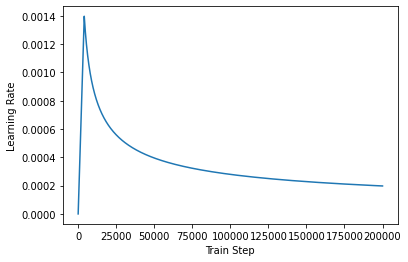

In [15]:
sample_learning_rate = LRScheduler(d_model=128)
plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")
plt.show()

In [16]:
n_layers = 2
d_model = 256
n_heads = 8
units = 512
dropout = 0.1

In [17]:
transformer = Transformer(
    tokenizer.vocab_size + 2, n_layers, units,
    d_model, n_heads, dropout, name="Transformer"
)

In [18]:
optimizer = tf.keras.optimizers.Adam(
    LRScheduler(d_model), beta_1=0.9,
    beta_2=0.98, epsilon=1e-9
)

In [19]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        y_pred = transformer(x, y)
        loss = loss_function(y, y_pred)
        acc = accuracy(y, y_pred)
    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    return loss, acc

In [20]:
def get_checkpoints(transformer, optimizer, checkpoint_dir='./checkpoints/train'):
    checkpoint = tf.train.Checkpoint(
        transformer=transformer,
        optimizer=optimizer
    )
    checkpoint_manager = tf.train.CheckpointManager(
        checkpoint, checkpoint_dir, max_to_keep=5
    )
    if checkpoint_manager.latest_checkpoint:
        checkpoint.restore(checkpoint_manager.latest_checkpoint)
    return checkpoint, checkpoint_manager

In [21]:
checkpoint, checkpoint_manager = get_checkpoints(transformer, optimizer, './checkpoints/')

In [22]:
def train(dataset, epochs):
    summary_writer = tf.summary.create_file_writer('logs')
    iteration = 0
    for epoch in range(1, epochs + 1):
        with summary_writer.as_default():
            for (batch, (source, target)) in tqdm(enumerate(dataset)):
                batch_loss, batch_accuracy = train_step(source, target)
                tf.summary.scalar('Train Loss', batch_loss, step=iteration)
                tf.summary.scalar('Train Accuracy', batch_accuracy, step=iteration)
                summary_writer.flush()
                iteration += 1
        checkpoint_manager.save()

In [23]:
%tensorboard --logdir logs

In [24]:
# train(dataset, epochs)